### Imports

Necessary imports.

In [173]:
import random
import logging
from typing import Callable
from collections import namedtuple
from matplotlib import pyplot as plt

logging.getLogger().setLevel(logging.INFO)

### Definition of the problem

Definition of the Set Covering problem with the homonym function. 

In [174]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

### Useful functions and parameters

I decided to use some global variables and data structures that can be used below in the other chuncks of code: <br>
* GENERATIONS_NUMBER is the maximum number of generations that I want my algorithm explores. <br>
* POPULATION_SIZE is the number of individual a single population has to own. <br>
* OFFSPRING_SIZE is the amount of new individuals my algorithm has to generate for each generation. <br>
* PROBLEM_NUMBER is the dimension of Set Covering problem. <br>
* GOAL is the complete set with PROBLEM_NUMBER members (the final state of the solution). <br>
* Individual is a namedtuple that will be used to contain one genome and its fitness value, in other words it will represents a single individual. <br>
* sets_list is the list of set generated by the function "problem", it contains all the sets. <br>
* GENOME_LENGTH is the dimension of a single genome, so the total number of genes. <br>

I will draw the single individual as a union of the genome and its fitness. The genome will be composed by an array of boolean where the cell i, represents if this genome are keepeing or not the set number i in the sets_list. <br>

Then there are some useful function for the algorithm: <br>
* calculate_steps collapses the different lists in one single set and counts the steps (so the number of lists used). <br>
* goal_reach takes the genome and using the calculate_steps function, compares it with the GOAL variable. <br>
* calculate_fintess checks what sets are keeping by a certain genome and by taking in count the numbers repetitions, the length of the sets and the number of sets, calculates the fitness value for the individual. <br>
* tournament takes the first n elements of a population, where n is decided by the user (default is 2), after sorts them with their fitnesses. <br>
* mutation randomly changes the genome of an individual (it changes the boolean values of the list). <br>
* crossover randomly merges two genomes. <br>

In [175]:
GENERATIONS_NUMBER = 20
POPULATION_SIZE = 10
OFFSPRING_SIZE = 5
PROBLEM_NUMBER = 10
GOAL = set(range(PROBLEM_NUMBER))
Individual = namedtuple("Individual", ["genome", "fitness"])
sets_list = problem(PROBLEM_NUMBER, seed=42)
GENOME_LENGTH = len(sets_list)

def calculate_steps(genome: list):
    solution = list()
    steps = 0
    for i,gene in enumerate(genome):
        if gene == True:
            solution.append(sets_list[i])
            steps += 1
    return solution, steps
    
def goal_reach(genome: list):
    solution = calculate_steps(genome)[0]
    final_set = set()
    for s in solution:
        final_set.update(s)
    return final_set == GOAL

def calculate_fitness(inner_genome: list):
    composed_set = set()
    total_weight = 0
    penalty = 0
    sets_number = 0
    for i,gene in enumerate(inner_genome):
        if gene == True:
            s = set(sets_list[i])
            penalty += len(list(composed_set.intersection(s)))
            composed_set = composed_set.union(s)
            total_weight += len(s)
            sets_number += 1
    return total_weight/(penalty+sets_number+1)

def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)

def mutation(genome: list):
    while random.random() < 0.7:
        tr = random.randint(0, GENOME_LENGTH-1)
        genome[tr] = not genome[tr]
    return genome

def crossover(genome_1: list, genome_2: list):
    cut = random.randint(0, GENOME_LENGTH-1)
    return genome_1[:cut] + genome_2[cut:]

### Define initial population

In this section I randomly initialize the population genomes and set the initial fitness value to zero for each individual.

In [176]:
population = [Individual(genome=[False for _ in range(GENOME_LENGTH)], fitness=0.0) for i in range(POPULATION_SIZE)]

### Evolution

This section is the core of the algorithm. <br>
I apply a random choice between mutation and crossover and for each generation I make a new population that is the same as the generation before plus the offspring list (made by mutations and crossovers of the individuals genomes). <br>
Obviously the new individuals have a new fitness value calculated after the changements in their genome. <br>
I add a fitness_log data structure that will be useful for the plots. <br>
The tuple find is needed for encapsulating a flag (for the early exit from the cycle in case the solution was found) and the list of sets which is the solution of the problem.

In [177]:
fitness_log = [(0, i.fitness) for i in population]
find = (False, list())
offspring = list()
parents = list()

for generation in range(GENERATIONS_NUMBER):
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random.random() < 0.3:
            selected_parent = tournament(population, tournament_size=3)
            if goal_reach(selected_parent.genome):
                find = (True, selected_parent.genome)
                break
            new_genome = mutation(selected_parent.genome)
        else:
            selected_parent1 = tournament(population)
            selected_parent2 = tournament(population)
            if goal_reach(selected_parent1.genome):
                find = (True, selected_parent1.genome)
                break
            if goal_reach(selected_parent2.genome):
                find = (True, selected_parent2.genome)
                break
            new_genome = crossover(selected_parent1.genome, selected_parent2.genome)
        new_fitness = calculate_fitness(new_genome)
        fitness_log.append((generation + 1, new_fitness))
        offspring.append(Individual(new_genome, new_fitness))
    if find[0] == True:
        ACTUAL_GENERATIONS = generation
        break
    population += offspring
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]

### Performances

Here I expose the result of my algorithm, both in numeric terms and in plots terms.

INFO:root: Find a solution in 5 steps; Total weight: 14; (bloat=40%)


[[9, 6], [8, 9, 3], [0, 3, 4, 7, 9], [2, 5], [1, 7]]


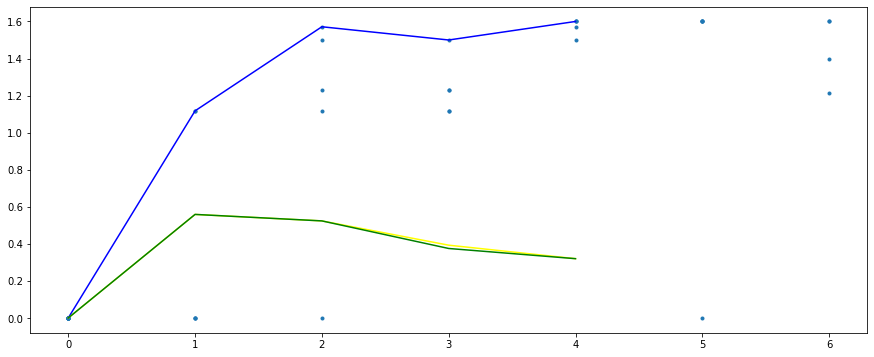

In [178]:
if find[0] == True:
    solution, steps = calculate_steps(find[1])
    logging.info(
        f" Find a solution in {steps} steps; "
        f"Total weight: {sum(len(_) for _ in solution)}; "
        f"(bloat={(sum(len(_) for _ in solution)-PROBLEM_NUMBER)/PROBLEM_NUMBER*100:.0f}%)"
    )
else:
    logging.info(
        f"Solution not found!"
    )
print(solution)
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(ACTUAL_GENERATIONS)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(ACTUAL_GENERATIONS)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(ACTUAL_GENERATIONS)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)], color='blue')
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)], color='yellow')
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)], color='green')